In [2]:
from symreg import Regressor
import pandas as pd
import numpy as np
import random
import traceback

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [2]:
diff_data, duration_per = 600, 3 # 30 minutes
# diff_data, duration_per = 180, 3 # 15 minutes
# diff_data, duration_per = 120, 1.8 # 3.6 minutes
# diff_data, duration_per   = 30, 3 # instant

X, y = load_boston(return_X_y=True)
X /= X.mean()
y /= y.mean()
X, Xt, y, yt = train_test_split(X, y, test_size=0.4, random_state=0)

results = []

def time_left(diff_data):
    return f'{diff_data * duration_per / 60} minutes'

print(f'Will take {time_left(diff_data)}')

def eval_settings(**settings):
    r = Regressor(verbose=True, duration=duration_per, **settings)
    r.fit(X, y)
    
    y_out = r.predict(Xt, max_complexity=10)
    error = np.median((yt - y_out) ** 2)
    return {**settings, **{'error': error}}


for i in range(diff_data):
    random.seed(i)
    muts = {    
        'hoist_mutation_chance': random.random(),
        'prune_mutation_chance': random.random(),
        'grow_root_mutation_chance': random.random(),
        'grow_leaf_mutation_chance': random.random(),
    }
    point_mut_chance = random.random()
    
    totalmut = point_mut_chance + sum(v for v in muts.values())
    
    muts = {k: v/totalmut for k, v in muts.items()}
        
    try:
        args = {
            **muts,
            'simplify_chance': random.random(),
        }

        results.append(eval_settings(**args))
        print(results[-1])
        print('------------', time_left(diff_data - i-1), 'left')
    except ValueError as e:
        print('------------', 'Value Error for seed', i, ': ', args)
        traceback.print_exc()


Will take 30.0 minutes
Time left  : 1.95s
Best so far: (0.3623518829450353, 28) (error, complexity)
Time left  : 0.95s
Best so far: (0.3436219266122378, 26) (error, complexity)
Complete. {'generations': 208, 'stagnated_generations': 0, 'duration': 3.0172770023345947}
{'hoist_mutation_chance': 0.3023199914954388, 'prune_mutation_chance': 0.27136290733950236, 'grow_root_mutation_chance': 0.15057307731955671, 'grow_leaf_mutation_chance': 0.09269739953463703, 'simplify_chance': 0.4049341374504143, 'error': 0.023124748355407808}
------------ 29.95 minutes left
Time left  : 1.99s
Best so far: (0.255307421925854, 19) (error, complexity)
Time left  : 0.98s
Best so far: (0.23336425335902333, 25) (error, complexity)
Complete. {'generations': 227, 'stagnated_generations': 0, 'duration': 3.0221846103668213}
{'hoist_mutation_chance': 0.05383017413698619, 'prune_mutation_chance': 0.3395062870351673, 'grow_root_mutation_chance': 0.30599004231012344, 'grow_leaf_mutation_chance': 0.10218797540377206, '

Time left  : 0.97s
Best so far: (0.21791009785032023, 42) (error, complexity)
Complete. {'generations': 212, 'stagnated_generations': 1, 'duration': 3.0149407386779785}
{'hoist_mutation_chance': 0.3378231888793266, 'prune_mutation_chance': 0.004079003239479465, 'grow_root_mutation_chance': 0.2575882519887007, 'grow_leaf_mutation_chance': 0.05530256115600401, 'simplify_chance': 0.016880654207976242, 'error': 0.018618183444284647}
------------ 29.2 minutes left
Time left  : 1.98s
Best so far: (0.2582405866136348, 42) (error, complexity)
Time left  : 0.96s
Best so far: (0.25347725570392166, 40) (error, complexity)
Complete. {'generations': 161, 'stagnated_generations': 3, 'duration': 3.0506443977355957}
{'hoist_mutation_chance': 0.17091408277500875, 'prune_mutation_chance': 0.2271528046106886, 'grow_root_mutation_chance': 0.1971191877299441, 'grow_leaf_mutation_chance': 0.21121061626027526, 'simplify_chance': 0.6577058263942708, 'error': 0.03549090192556402}
------------ 29.15 minutes lef

Time left  : 1.99s
Best so far: (0.36250406579872485, 15) (error, complexity)
Time left  : 0.98s
Best so far: (0.36181767480335136, 63) (error, complexity)
Complete. {'generations': 222, 'stagnated_generations': 0, 'duration': 3.0310091972351074}
{'hoist_mutation_chance': 0.3130628835819702, 'prune_mutation_chance': 0.16794614861983684, 'grow_root_mutation_chance': 0.017443447934970283, 'grow_leaf_mutation_chance': 0.37958837281993263, 'simplify_chance': 0.2572769749796092, 'error': 0.013793044604306597}
------------ 28.45 minutes left
Time left  : 1.99s
Best so far: (0.22524327756711052, 47) (error, complexity)
Time left  : 0.98s
Best so far: (0.21356075341802155, 53) (error, complexity)
Complete. {'generations': 174, 'stagnated_generations': 1, 'duration': 3.0346479415893555}
{'hoist_mutation_chance': 0.009162394770576556, 'prune_mutation_chance': 0.08387538576149908, 'grow_root_mutation_chance': 0.2931469671928183, 'grow_leaf_mutation_chance': 0.5103199373475337, 'simplify_chance': 

Time left  : 0.99s
Best so far: (0.22865599588131388, 38) (error, complexity)
Complete. {'generations': 231, 'stagnated_generations': 3, 'duration': 3.0175857543945312}
{'hoist_mutation_chance': 0.21700554856118684, 'prune_mutation_chance': 0.3895344093467848, 'grow_root_mutation_chance': 0.06535446262155276, 'grow_leaf_mutation_chance': 0.2703703324086193, 'simplify_chance': 0.011036367079899967, 'error': 0.01872928240922339}
------------ 27.7 minutes left
Time left  : 1.98s
Best so far: (0.2870027750417716, 31) (error, complexity)
Time left  : 0.98s
Best so far: (0.21232845091833608, 93) (error, complexity)
Complete. {'generations': 167, 'stagnated_generations': 0, 'duration': 3.040750503540039}
{'hoist_mutation_chance': 0.29956344278487507, 'prune_mutation_chance': 0.1348958738112912, 'grow_root_mutation_chance': 0.19850886586932626, 'grow_leaf_mutation_chance': 0.28995824888321486, 'simplify_chance': 0.5157172840235198, 'error': 0.02266971779189564}
------------ 27.65 minutes left


Time left  : 1.97s
Best so far: (0.23798029941453994, 207) (error, complexity)
Time left  : 0.96s
Best so far: (0.21786789185807418, 335) (error, complexity)
Time left  : -0.09s
Best so far: (0.21634275014598817, 750) (error, complexity)
Complete. {'generations': 85, 'stagnated_generations': 0, 'duration': 3.2150633335113525}
{'hoist_mutation_chance': 0.19759698457220135, 'prune_mutation_chance': 0.22245379601107304, 'grow_root_mutation_chance': 0.3235728860292143, 'grow_leaf_mutation_chance': 0.1281178552195325, 'simplify_chance': 0.6931668373027555, 'error': 0.013053053455911142}
------------ 26.9 minutes left
Time left  : 1.98s
Best so far: (0.26700382405110246, 19) (error, complexity)
Time left  : 0.97s
Best so far: (0.22436302304342737, 40) (error, complexity)
Complete. {'generations': 173, 'stagnated_generations': 0, 'duration': 3.058720588684082}
{'hoist_mutation_chance': 0.334470650168261, 'prune_mutation_chance': 0.062363084470737615, 'grow_root_mutation_chance': 0.34983818709

Time left  : 1.98s
Best so far: (0.2665932700646291, 24) (error, complexity)
Time left  : 0.96s
Best so far: (0.2562989040739369, 43) (error, complexity)
Complete. {'generations': 184, 'stagnated_generations': 9, 'duration': 3.0242085456848145}
{'hoist_mutation_chance': 0.16573160478650842, 'prune_mutation_chance': 0.42497081330421577, 'grow_root_mutation_chance': 0.08947086046651727, 'grow_leaf_mutation_chance': 0.13282179432961377, 'simplify_chance': 0.2373052036883777, 'error': 0.042291541698546486}
------------ 26.15 minutes left
Time left  : 1.98s
Best so far: (0.3329335917443857, 58) (error, complexity)
Time left  : 0.95s
Best so far: (0.21374962953951024, 67) (error, complexity)
Complete. {'generations': 154, 'stagnated_generations': 0, 'duration': 3.040440320968628}
{'hoist_mutation_chance': 0.3469687674650683, 'prune_mutation_chance': 0.14150554160866566, 'grow_root_mutation_chance': 0.10442013974003343, 'grow_leaf_mutation_chance': 0.35714642365256144, 'simplify_chance': 0.47

Time left  : 0.92s
Best so far: (0.19768857322160607, 103) (error, complexity)
Complete. {'generations': 92, 'stagnated_generations': 0, 'duration': 3.053504228591919}
{'hoist_mutation_chance': 0.040736251562506334, 'prune_mutation_chance': 0.0840737470409039, 'grow_root_mutation_chance': 0.3335218573209709, 'grow_leaf_mutation_chance': 0.07870147419993569, 'simplify_chance': 0.8443280218706307, 'error': 0.02351759018487625}
------------ 25.4 minutes left
Time left  : 1.97s
Best so far: (0.22166045305314339, 11) (error, complexity)
Time left  : 0.95s
Best so far: (0.21163738778456034, 56) (error, complexity)
Complete. {'generations': 174, 'stagnated_generations': 3, 'duration': 3.0328805446624756}
{'hoist_mutation_chance': 0.1435184558947734, 'prune_mutation_chance': 0.19255842964111444, 'grow_root_mutation_chance': 0.19024932870498687, 'grow_leaf_mutation_chance': 0.20071711691934843, 'simplify_chance': 0.966876781563112, 'error': 0.017633266959344456}
------------ 25.35 minutes left


Complete. {'generations': 200, 'stagnated_generations': 3, 'duration': 3.033085823059082}
{'hoist_mutation_chance': 0.20954098077152405, 'prune_mutation_chance': 0.26568634297234883, 'grow_root_mutation_chance': 0.00494267284394701, 'grow_leaf_mutation_chance': 0.27776188511912103, 'simplify_chance': 0.05668495560658604, 'error': 0.016075890686966583}
------------ 24.65 minutes left
Time left  : 1.99s
Best so far: (0.21093020463868928, 29) (error, complexity)
Time left  : 0.97s
Best so far: (0.20429033383741022, 49) (error, complexity)
Complete. {'generations': 182, 'stagnated_generations': 2, 'duration': 3.05414080619812}
{'hoist_mutation_chance': 0.08382697429270085, 'prune_mutation_chance': 0.19769307302181205, 'grow_root_mutation_chance': 0.33066669496692613, 'grow_leaf_mutation_chance': 0.22371114064502373, 'simplify_chance': 0.30898383972761845, 'error': 0.022785398369964054}
------------ 24.6 minutes left
Time left  : 1.99s
Best so far: (0.20405776169665368, 45) (error, complexi

Time left  : 1.99s
Best so far: (0.21496237100867416, 21) (error, complexity)
Time left  : 0.98s
Best so far: (0.2047733485352434, 23) (error, complexity)
Complete. {'generations': 204, 'stagnated_generations': 0, 'duration': 3.0322515964508057}
{'hoist_mutation_chance': 0.16617937785664894, 'prune_mutation_chance': 0.19451994267934547, 'grow_root_mutation_chance': 0.0984978467793531, 'grow_leaf_mutation_chance': 0.303032297361293, 'simplify_chance': 0.7610144333556674, 'error': 0.014909248364398168}
------------ 23.85 minutes left
Time left  : 1.99s
Best so far: (0.23345446267804917, 25) (error, complexity)
Time left  : 0.99s
Best so far: (0.21161767797035816, 53) (error, complexity)
Time left  : -0.02s
Best so far: (0.20969638421668152, 53) (error, complexity)
Complete. {'generations': 230, 'stagnated_generations': 7, 'duration': 3.030299186706543}
{'hoist_mutation_chance': 0.03365937946756594, 'prune_mutation_chance': 0.05604369309306287, 'grow_root_mutation_chance': 0.2617754577457

Time left  : 1.98s
Best so far: (0.28851319993746255, 23) (error, complexity)
Time left  : 0.98s
Best so far: (0.20890105186342073, 39) (error, complexity)
Complete. {'generations': 193, 'stagnated_generations': 4, 'duration': 3.0437073707580566}
{'hoist_mutation_chance': 0.035259210876924074, 'prune_mutation_chance': 0.19981089993810142, 'grow_root_mutation_chance': 0.482482419875118, 'grow_leaf_mutation_chance': 0.11251239384759915, 'simplify_chance': 0.8206446275478789, 'error': 0.023596584915146896}
------------ 23.1 minutes left
Time left  : 1.99s
Best so far: (0.2471950512281125, 40) (error, complexity)
Time left  : 0.98s
Best so far: (0.2231542511599312, 46) (error, complexity)
Complete. {'generations': 187, 'stagnated_generations': 0, 'duration': 3.0362942218780518}
{'hoist_mutation_chance': 0.0801830407280109, 'prune_mutation_chance': 0.18657761796170194, 'grow_root_mutation_chance': 0.2894026534258028, 'grow_leaf_mutation_chance': 0.08632309772999856, 'simplify_chance': 0.247

Time left  : 1.96s
Best so far: (0.2874014346078585, 133) (error, complexity)
Time left  : 0.93s
Best so far: (0.21993630040573497, 44) (error, complexity)
Complete. {'generations': 105, 'stagnated_generations': 0, 'duration': 3.028567314147949}
{'hoist_mutation_chance': 0.2975869531432246, 'prune_mutation_chance': 0.11915323809771075, 'grow_root_mutation_chance': 0.044496029131234, 'grow_leaf_mutation_chance': 0.2957460133811177, 'simplify_chance': 0.6246724949575524, 'error': 0.01708308908835437}
------------ 22.35 minutes left
Time left  : 1.97s
Best so far: (0.2398083721304614, 49) (error, complexity)
Time left  : 0.97s
Best so far: (0.22641044735842783, 46) (error, complexity)
Complete. {'generations': 182, 'stagnated_generations': 0, 'duration': 3.0352275371551514}
{'hoist_mutation_chance': 0.3229137632435431, 'prune_mutation_chance': 0.024597102723162356, 'grow_root_mutation_chance': 0.08452151459958962, 'grow_leaf_mutation_chance': 0.27681284409532164, 'simplify_chance': 0.5661

Time left  : 1.99s
Best so far: (0.282202214137797, 31) (error, complexity)
Time left  : 0.98s
Best so far: (0.22910384191011457, 97) (error, complexity)
Complete. {'generations': 163, 'stagnated_generations': 1, 'duration': 3.0380077362060547}
{'hoist_mutation_chance': 0.09238890616314091, 'prune_mutation_chance': 0.03548380246862994, 'grow_root_mutation_chance': 0.17142032402238425, 'grow_leaf_mutation_chance': 0.3903447048725335, 'simplify_chance': 0.7223165562974653, 'error': 0.02929738379392765}
------------ 21.6 minutes left
Time left  : 1.99s
Best so far: (0.24762386184834248, 13) (error, complexity)
Time left  : 0.98s
Best so far: (0.2028146659180382, 59) (error, complexity)
Complete. {'generations': 203, 'stagnated_generations': 3, 'duration': 3.024653911590576}
{'hoist_mutation_chance': 0.3629991590545855, 'prune_mutation_chance': 0.25173535539025454, 'grow_root_mutation_chance': 0.18483248727230644, 'grow_leaf_mutation_chance': 0.10790587821129942, 'simplify_chance': 0.86341

Time left  : 1.98s
Best so far: (0.24237191921886445, 31) (error, complexity)
Time left  : 0.97s
Best so far: (0.2173688634237132, 26) (error, complexity)
Time left  : -0.03s
Best so far: (0.2080032575110311, 77) (error, complexity)
Complete. {'generations': 174, 'stagnated_generations': 0, 'duration': 3.05637526512146}
{'hoist_mutation_chance': 0.20184718386642048, 'prune_mutation_chance': 0.104235587018637, 'grow_root_mutation_chance': 0.41141932448547464, 'grow_leaf_mutation_chance': 0.15566388788180596, 'simplify_chance': 0.7846042790422948, 'error': 0.01618087773457589}
------------ 20.85 minutes left
Time left  : 1.98s
Best so far: (0.27104488848869646, 12) (error, complexity)
Time left  : 0.98s
Best so far: (0.24720607367671424, 74) (error, complexity)
Complete. {'generations': 156, 'stagnated_generations': 1, 'duration': 3.0320122241973877}
{'hoist_mutation_chance': 0.0783181289836918, 'prune_mutation_chance': 0.5423000492897391, 'grow_root_mutation_chance': 0.00095413620722137

Time left  : 1.99s
Best so far: (0.23917074354849793, 21) (error, complexity)
Time left  : 0.98s
Best so far: (0.23062162927004662, 23) (error, complexity)
Complete. {'generations': 272, 'stagnated_generations': 2, 'duration': 3.0206549167633057}
{'hoist_mutation_chance': 0.5407047946462671, 'prune_mutation_chance': 0.13273418443296495, 'grow_root_mutation_chance': 0.021180389798090955, 'grow_leaf_mutation_chance': 0.18790360837583417, 'simplify_chance': 0.5814724973187521, 'error': 0.02864316329500945}
------------ 20.1 minutes left
Time left  : 1.99s
Best so far: (0.27256590243975415, 16) (error, complexity)
Time left  : 0.98s
Best so far: (0.21340541615317765, 32) (error, complexity)
Complete. {'generations': 268, 'stagnated_generations': 0, 'duration': 3.01633358001709}
{'hoist_mutation_chance': 0.025376346959407416, 'prune_mutation_chance': 0.34078918760823124, 'grow_root_mutation_chance': 0.04831824192081468, 'grow_leaf_mutation_chance': 0.35639503247808996, 'simplify_chance': 0.

Time left  : 1.98s
Best so far: (0.20786015860921286, 49) (error, complexity)
Time left  : 0.98s
Best so far: (0.20320051381592769, 39) (error, complexity)
Complete. {'generations': 202, 'stagnated_generations': 0, 'duration': 3.035606622695923}
{'hoist_mutation_chance': 0.146652971700593, 'prune_mutation_chance': 0.3635663001613057, 'grow_root_mutation_chance': 0.26103309875916914, 'grow_leaf_mutation_chance': 0.022020794307364342, 'simplify_chance': 0.15576320087899664, 'error': 0.013587717516394838}
------------ 19.35 minutes left
Time left  : 1.99s
Best so far: (0.27313725669979955, 20) (error, complexity)
Time left  : 0.98s
Best so far: (0.2232953136048921, 27) (error, complexity)
Complete. {'generations': 247, 'stagnated_generations': 2, 'duration': 3.0258986949920654}
{'hoist_mutation_chance': 0.11529375922451322, 'prune_mutation_chance': 0.16708944465114642, 'grow_root_mutation_chance': 0.015079779582216145, 'grow_leaf_mutation_chance': 0.3154914085228718, 'simplify_chance': 0.

Time left  : 0.98s
Best so far: (0.22117603130617275, 39) (error, complexity)
Complete. {'generations': 201, 'stagnated_generations': 1, 'duration': 3.0295867919921875}
{'hoist_mutation_chance': 0.14265707064824742, 'prune_mutation_chance': 0.2917382365092311, 'grow_root_mutation_chance': 0.24560351603685301, 'grow_leaf_mutation_chance': 0.029032335115260363, 'simplify_chance': 0.7459746555626608, 'error': 0.019101083903317065}
------------ 18.6 minutes left
Time left  : 1.98s
Best so far: (0.22145325151494197, 11) (error, complexity)
Time left  : 0.98s
Best so far: (0.19481907153268643, 15) (error, complexity)
Complete. {'generations': 252, 'stagnated_generations': 18, 'duration': 3.016893148422241}
{'hoist_mutation_chance': 0.36373672404071966, 'prune_mutation_chance': 0.27506203770027693, 'grow_root_mutation_chance': 0.08714903021236763, 'grow_leaf_mutation_chance': 0.0894054307688599, 'simplify_chance': 0.9311470359817681, 'error': 0.023146881604731762}
------------ 18.55 minutes l

Time left  : 0.99s
Best so far: (0.26127435632915846, 17) (error, complexity)
Complete. {'generations': 218, 'stagnated_generations': 2, 'duration': 3.018608808517456}
{'hoist_mutation_chance': 0.11439973536642711, 'prune_mutation_chance': 0.1692350410260209, 'grow_root_mutation_chance': 0.3281464967975826, 'grow_leaf_mutation_chance': 0.21301688338283345, 'simplify_chance': 0.7755822850155515, 'error': 0.027361812492798565}
------------ 17.85 minutes left
Time left  : 1.99s
Best so far: (0.29242480714124386, 54) (error, complexity)
Time left  : 0.96s
Best so far: (0.24993089837096746, 141) (error, complexity)
Complete. {'generations': 180, 'stagnated_generations': 0, 'duration': 3.050309181213379}
{'hoist_mutation_chance': 0.36422511330887464, 'prune_mutation_chance': 0.19577411901276098, 'grow_root_mutation_chance': 0.15805638588564389, 'grow_leaf_mutation_chance': 0.16787365759428854, 'simplify_chance': 0.2623951220684694, 'error': 0.024170806720643156}
------------ 17.8 minutes lef

Time left  : 1.98s
Best so far: (0.2601471584945686, 32) (error, complexity)
Time left  : 0.98s
Best so far: (0.2475309131854918, 41) (error, complexity)
Complete. {'generations': 163, 'stagnated_generations': 1, 'duration': 3.0366110801696777}
{'hoist_mutation_chance': 0.21341234924718816, 'prune_mutation_chance': 0.06835500604371138, 'grow_root_mutation_chance': 0.3576196911604022, 'grow_leaf_mutation_chance': 0.3524413395973949, 'simplify_chance': 0.8368480950939333, 'error': 0.012730793311427593}
------------ 17.1 minutes left
Time left  : 1.99s
Best so far: (0.22710174761192092, 13) (error, complexity)
Time left  : 0.98s
Best so far: (0.22015879418027584, 23) (error, complexity)
Complete. {'generations': 263, 'stagnated_generations': 11, 'duration': 3.01867413520813}
{'hoist_mutation_chance': 0.29325375741586057, 'prune_mutation_chance': 0.03270096749791083, 'grow_root_mutation_chance': 0.4179009703710527, 'grow_leaf_mutation_chance': 0.1931776930220441, 'simplify_chance': 0.22899

Time left  : 1.99s
Best so far: (0.33530778829027924, 22) (error, complexity)
Time left  : 0.97s
Best so far: (0.22892921752124926, 36) (error, complexity)
Complete. {'generations': 172, 'stagnated_generations': 0, 'duration': 3.045718193054199}
{'hoist_mutation_chance': 0.3427176280908023, 'prune_mutation_chance': 0.12565156883140818, 'grow_root_mutation_chance': 0.22836387535207067, 'grow_leaf_mutation_chance': 0.17441433393955474, 'simplify_chance': 0.6899823814441232, 'error': 0.023596584915146896}
------------ 16.35 minutes left
Time left  : 1.99s
Best so far: (0.3233613092603656, 60) (error, complexity)
Time left  : 0.98s
Best so far: (0.24424567365997385, 71) (error, complexity)
Time left  : -0.03s
Best so far: (0.20988699192595814, 168) (error, complexity)
Complete. {'generations': 148, 'stagnated_generations': 0, 'duration': 3.0700438022613525}
{'hoist_mutation_chance': 0.0807869948225392, 'prune_mutation_chance': 0.26638890321829667, 'grow_root_mutation_chance': 0.10067534186

Time left  : 0.98s
Best so far: (0.23244834725609415, 15) (error, complexity)
Complete. {'generations': 235, 'stagnated_generations': 2, 'duration': 3.0149643421173096}
{'hoist_mutation_chance': 0.31364204130255297, 'prune_mutation_chance': 0.17690140432160162, 'grow_root_mutation_chance': 0.0670526625394816, 'grow_leaf_mutation_chance': 0.0939374506304112, 'simplify_chance': 0.5138828771179134, 'error': 0.016039909229797464}
------------ 15.6 minutes left
Time left  : 1.98s
Best so far: (0.22939580373858692, 76) (error, complexity)
Time left  : 0.98s
Best so far: (0.21237194644692683, 91) (error, complexity)
Complete. {'generations': 137, 'stagnated_generations': 0, 'duration': 3.0645346641540527}
{'hoist_mutation_chance': 0.32064742891241405, 'prune_mutation_chance': 0.09646242058013228, 'grow_root_mutation_chance': 0.169092663633931, 'grow_leaf_mutation_chance': 0.25238832201523403, 'simplify_chance': 0.5098558547317137, 'error': 0.013579866926649566}
------------ 15.55 minutes left

Complete. {'generations': 236, 'stagnated_generations': 0, 'duration': 3.029637098312378}
{'hoist_mutation_chance': 0.35465382961757647, 'prune_mutation_chance': 0.19805649532473882, 'grow_root_mutation_chance': 0.20336029095503103, 'grow_leaf_mutation_chance': 0.17447849288416542, 'simplify_chance': 0.03754044605849893, 'error': 0.014743504893683384}
------------ 14.85 minutes left
Time left  : 1.99s
Best so far: (0.26089108720878246, 15) (error, complexity)
Time left  : 0.98s
Best so far: (0.2173723739352465, 93) (error, complexity)
Complete. {'generations': 216, 'stagnated_generations': 0, 'duration': 3.034210681915283}
{'hoist_mutation_chance': 0.010093198995514807, 'prune_mutation_chance': 0.3088790071784364, 'grow_root_mutation_chance': 0.06214080598379272, 'grow_leaf_mutation_chance': 0.31704132063210383, 'simplify_chance': 0.2586761829758428, 'error': 0.022666674826559933}
------------ 14.8 minutes left
Time left  : 1.99s
Best so far: (0.33742277051415126, 23) (error, complexit

Time left  : 0.99s
Best so far: (0.23116277136627578, 76) (error, complexity)
Complete. {'generations': 165, 'stagnated_generations': 0, 'duration': 3.031848430633545}
{'hoist_mutation_chance': 0.2001236043666448, 'prune_mutation_chance': 0.30517431686537755, 'grow_root_mutation_chance': 0.16680331887256936, 'grow_leaf_mutation_chance': 0.08678452338316704, 'simplify_chance': 0.7056959008758983, 'error': 0.02156821716138343}
------------ 14.1 minutes left
Time left  : 1.98s
Best so far: (0.2149566151592556, 30) (error, complexity)
Time left  : 0.98s
Best so far: (0.20839233279860478, 43) (error, complexity)
Complete. {'generations': 166, 'stagnated_generations': 2, 'duration': 3.037525177001953}
{'hoist_mutation_chance': 0.3192953038802247, 'prune_mutation_chance': 0.021438033275812403, 'grow_root_mutation_chance': 0.18306876410677658, 'grow_leaf_mutation_chance': 0.1918705452695399, 'simplify_chance': 0.6633073188696071, 'error': 0.023321374865868}
------------ 14.05 minutes left
Time

Time left  : 1.98s
Best so far: (0.23305499332108512, 69) (error, complexity)
Time left  : 0.98s
Best so far: (0.22094398693038064, 18) (error, complexity)
Complete. {'generations': 270, 'stagnated_generations': 7, 'duration': 3.0565004348754883}
{'hoist_mutation_chance': 0.10153934375826631, 'prune_mutation_chance': 0.21569857336570508, 'grow_root_mutation_chance': 0.23646936031787408, 'grow_leaf_mutation_chance': 0.2860422915145302, 'simplify_chance': 0.0002096237568171011, 'error': 0.017117174390871095}
------------ 13.35 minutes left
Time left  : 1.98s
Best so far: (0.22713785246721444, 21) (error, complexity)
Time left  : 0.98s
Best so far: (0.21886872844443211, 20) (error, complexity)
Complete. {'generations': 245, 'stagnated_generations': 0, 'duration': 3.0156543254852295}
{'hoist_mutation_chance': 0.2209787486582328, 'prune_mutation_chance': 0.14064579558701834, 'grow_root_mutation_chance': 0.3915319197341838, 'grow_leaf_mutation_chance': 0.03268856268986028, 'simplify_chance':

Time left  : 1.98s
Best so far: (0.2853783453553875, 77) (error, complexity)
Time left  : 0.96s
Best so far: (0.21494270018551528, 54) (error, complexity)
Complete. {'generations': 168, 'stagnated_generations': 2, 'duration': 3.0512430667877197}
{'hoist_mutation_chance': 0.11909549165209186, 'prune_mutation_chance': 0.15965621844012368, 'grow_root_mutation_chance': 0.30220431483815896, 'grow_leaf_mutation_chance': 0.16833820353616175, 'simplify_chance': 0.8681667471603661, 'error': 0.040470558518728}
------------ 12.6 minutes left
Time left  : 1.99s
Best so far: (0.22059645603412967, 36) (error, complexity)
Time left  : 0.98s
Best so far: (0.20502492681950746, 61) (error, complexity)
Complete. {'generations': 222, 'stagnated_generations': 3, 'duration': 3.0233678817749023}
{'hoist_mutation_chance': 0.2993763244702746, 'prune_mutation_chance': 0.26373478226416197, 'grow_root_mutation_chance': 0.06287499362394669, 'grow_leaf_mutation_chance': 0.08326850311397481, 'simplify_chance': 0.089

Complete. {'generations': 198, 'stagnated_generations': 0, 'duration': 3.0219905376434326}
{'hoist_mutation_chance': 0.3056853955413117, 'prune_mutation_chance': 0.20898708294945717, 'grow_root_mutation_chance': 0.24297318144829116, 'grow_leaf_mutation_chance': 0.14522224477858772, 'simplify_chance': 0.6534687605403657, 'error': 0.024195369594094022}
------------ 11.85 minutes left
Time left  : 1.99s
Best so far: (0.2619175688867976, 20) (error, complexity)
Time left  : 0.99s
Best so far: (0.24658929196979776, 15) (error, complexity)
Complete. {'generations': 222, 'stagnated_generations': 0, 'duration': 3.0319957733154297}
{'hoist_mutation_chance': 0.3091009460097711, 'prune_mutation_chance': 0.3273542204683791, 'grow_root_mutation_chance': 0.21241250478124266, 'grow_leaf_mutation_chance': 0.11824264393461238, 'simplify_chance': 0.8578108896690063, 'error': 0.019451817982735972}
------------ 11.8 minutes left
Time left  : 1.99s
Best so far: (0.25676643079458206, 9) (error, complexity)


Time left  : 1.99s
Best so far: (0.24953926279576635, 48) (error, complexity)
Time left  : 0.98s
Best so far: (0.19871567701053314, 147) (error, complexity)
Time left  : -0.04s
Best so far: (0.19586493621219075, 114) (error, complexity)
Complete. {'generations': 144, 'stagnated_generations': 0, 'duration': 3.0804333686828613}
{'hoist_mutation_chance': 0.00988534128163529, 'prune_mutation_chance': 0.3081331807544127, 'grow_root_mutation_chance': 0.30483000735796417, 'grow_leaf_mutation_chance': 0.06337395479454554, 'simplify_chance': 0.42690352953622834, 'error': 0.028007456107663236}
------------ 11.05 minutes left
Time left  : 1.98s
Best so far: (0.2548047101964262, 9) (error, complexity)
Time left  : 0.96s
Best so far: (0.2054534139951249, 32) (error, complexity)
Complete. {'generations': 185, 'stagnated_generations': 6, 'duration': 3.0421013832092285}
{'hoist_mutation_chance': 0.010619533626012766, 'prune_mutation_chance': 0.18332372999128807, 'grow_root_mutation_chance': 0.26303582

Time left  : 1.95s
Best so far: (0.2652487044305541, 34) (error, complexity)
Time left  : 0.93s
Best so far: (0.21929953640070035, 64) (error, complexity)
Complete. {'generations': 191, 'stagnated_generations': 1, 'duration': 3.0437726974487305}
{'hoist_mutation_chance': 0.2129164004964595, 'prune_mutation_chance': 0.09606963076661285, 'grow_root_mutation_chance': 0.002202511062792617, 'grow_leaf_mutation_chance': 0.42769528436002396, 'simplify_chance': 0.1368449334268279, 'error': 0.024761957883007314}
------------ 10.3 minutes left
Time left  : 1.99s
Best so far: (0.22839535253934026, 28) (error, complexity)
Time left  : 0.98s
Best so far: (0.22397837832369893, 26) (error, complexity)
Complete. {'generations': 225, 'stagnated_generations': 0, 'duration': 3.0244390964508057}
{'hoist_mutation_chance': 0.3555688732756157, 'prune_mutation_chance': 0.08945165209746501, 'grow_root_mutation_chance': 0.25521024479597365, 'grow_leaf_mutation_chance': 0.18031875587039028, 'simplify_chance': 0.

Complete. {'generations': 244, 'stagnated_generations': 1, 'duration': 3.028472900390625}
{'hoist_mutation_chance': 0.26719824357929456, 'prune_mutation_chance': 0.1474072194783976, 'grow_root_mutation_chance': 0.31531617104709636, 'grow_leaf_mutation_chance': 0.0791518913601534, 'simplify_chance': 0.4353899173631367, 'error': 0.02901397773418744}
------------ 9.55 minutes left
Time left  : 1.97s
Best so far: (0.2373751348881276, 14) (error, complexity)
Time left  : 0.97s
Best so far: (0.20640429335443214, 29) (error, complexity)
Complete. {'generations': 222, 'stagnated_generations': 30, 'duration': 3.032846212387085}
{'hoist_mutation_chance': 0.2691665413845666, 'prune_mutation_chance': 0.17839074150287623, 'grow_root_mutation_chance': 0.048913450437067046, 'grow_leaf_mutation_chance': 0.2968462188157565, 'simplify_chance': 0.433216317549606, 'error': 0.025362897714809665}
------------ 9.5 minutes left
Time left  : 1.99s
Best so far: (0.3108664861225668, 5) (error, complexity)
Time l

Time left  : 0.97s
Best so far: (0.26394205490328704, 43) (error, complexity)
Complete. {'generations': 152, 'stagnated_generations': 0, 'duration': 3.0295162200927734}
{'hoist_mutation_chance': 0.09920172445612467, 'prune_mutation_chance': 0.16589857813461328, 'grow_root_mutation_chance': 0.23477838512472146, 'grow_leaf_mutation_chance': 0.28264390116865534, 'simplify_chance': 0.931963857373492, 'error': 0.02332802903332253}
------------ 8.8 minutes left
Time left  : 1.98s
Best so far: (0.2980154894385523, 11) (error, complexity)
Time left  : 0.98s
Best so far: (0.23230196328479827, 12) (error, complexity)
Complete. {'generations': 252, 'stagnated_generations': 10, 'duration': 3.013890504837036}
{'hoist_mutation_chance': 0.19830583355452353, 'prune_mutation_chance': 0.28317726027809786, 'grow_root_mutation_chance': 0.2534721886568602, 'grow_leaf_mutation_chance': 0.021378853985000796, 'simplify_chance': 0.41366565279023526, 'error': 0.018598810094435456}
------------ 8.75 minutes left

Time left  : 1.99s
Best so far: (0.22112208565420963, 20) (error, complexity)
Time left  : 0.98s
Best so far: (0.21365946386180584, 51) (error, complexity)
Complete. {'generations': 199, 'stagnated_generations': 2, 'duration': 3.031419038772583}
{'hoist_mutation_chance': 0.07778027139023168, 'prune_mutation_chance': 0.21533943435535405, 'grow_root_mutation_chance': 0.32338458151001315, 'grow_leaf_mutation_chance': 0.2768173856575794, 'simplify_chance': 0.5918161976132206, 'error': 0.029096404391389556}
------------ 8.05 minutes left
Time left  : 1.98s
Best so far: (0.23028369547401675, 26) (error, complexity)
Time left  : 0.96s
Best so far: (0.17985002924722268, 33) (error, complexity)
Complete. {'generations': 195, 'stagnated_generations': 1, 'duration': 3.024656057357788}
{'hoist_mutation_chance': 0.1544858386186547, 'prune_mutation_chance': 0.11912515386900893, 'grow_root_mutation_chance': 0.10432334627479113, 'grow_leaf_mutation_chance': 0.3268043278534165, 'simplify_chance': 0.603

Time left  : 0.96s
Best so far: (0.22936115024814352, 20) (error, complexity)
Complete. {'generations': 178, 'stagnated_generations': 2, 'duration': 3.033783435821533}
{'hoist_mutation_chance': 0.09408673760427692, 'prune_mutation_chance': 0.21205976416883418, 'grow_root_mutation_chance': 0.26427394331394916, 'grow_leaf_mutation_chance': 0.15290665986116633, 'simplify_chance': 0.8546820396704038, 'error': 0.014233594747999708}
------------ 7.3 minutes left
Time left  : 1.97s
Best so far: (0.31399629866892553, 34) (error, complexity)
Time left  : 0.96s
Best so far: (0.21180989831841912, 54) (error, complexity)
Complete. {'generations': 181, 'stagnated_generations': 2, 'duration': 3.0315394401550293}
{'hoist_mutation_chance': 0.13230530358320652, 'prune_mutation_chance': 0.3261431367878022, 'grow_root_mutation_chance': 0.2845293903032836, 'grow_leaf_mutation_chance': 0.14226128530307341, 'simplify_chance': 0.5447050199499618, 'error': 0.02020554219333816}
------------ 7.25 minutes left
T

Time left  : 0.98s
Best so far: (0.23100905554868045, 22) (error, complexity)
Complete. {'generations': 294, 'stagnated_generations': 0, 'duration': 3.027958869934082}
{'hoist_mutation_chance': 0.3563355853468557, 'prune_mutation_chance': 0.13626221553843035, 'grow_root_mutation_chance': 0.2102639333551917, 'grow_leaf_mutation_chance': 0.06692997970965929, 'simplify_chance': 0.3820401068857986, 'error': 0.01761713291980306}
------------ 6.55 minutes left
Time left  : 1.98s
Best so far: (0.2737516308850556, 23) (error, complexity)
Time left  : 0.98s
Best so far: (0.2115298873413911, 72) (error, complexity)
Complete. {'generations': 205, 'stagnated_generations': 0, 'duration': 3.035390615463257}
{'hoist_mutation_chance': 0.12543708275981105, 'prune_mutation_chance': 0.14106410558129773, 'grow_root_mutation_chance': 0.12026184913096997, 'grow_leaf_mutation_chance': 0.3050117381406783, 'simplify_chance': 0.0939725245781805, 'error': 0.033340968666528956}
------------ 6.5 minutes left
Time 

Time left  : 0.96s
Best so far: (0.2162732543014847, 64) (error, complexity)
Complete. {'generations': 161, 'stagnated_generations': 2, 'duration': 3.0277180671691895}
{'hoist_mutation_chance': 0.29786562875502404, 'prune_mutation_chance': 0.4543675359671613, 'grow_root_mutation_chance': 0.17693723301148398, 'grow_leaf_mutation_chance': 0.04622544537026614, 'simplify_chance': 0.9860679196139566, 'error': 0.02003008375936674}
------------ 5.8 minutes left
Time left  : 1.99s
Best so far: (0.2612526422578714, 29) (error, complexity)
Time left  : 0.99s
Best so far: (0.24345536611286034, 17) (error, complexity)
Complete. {'generations': 288, 'stagnated_generations': 8, 'duration': 3.0197653770446777}
{'hoist_mutation_chance': 0.4096110042036535, 'prune_mutation_chance': 0.31744583304621404, 'grow_root_mutation_chance': 0.02922836703132821, 'grow_leaf_mutation_chance': 0.06818077349806068, 'simplify_chance': 0.11184730361348993, 'error': 0.013062140976549619}
------------ 5.75 minutes left
T

Time left  : 1.99s
Best so far: (0.2064073878169706, 28) (error, complexity)
Time left  : 0.98s
Best so far: (0.20589004723457985, 28) (error, complexity)
Complete. {'generations': 194, 'stagnated_generations': 1, 'duration': 3.0257840156555176}
{'hoist_mutation_chance': 0.23050809911849618, 'prune_mutation_chance': 0.29213896333651, 'grow_root_mutation_chance': 0.11849026502708324, 'grow_leaf_mutation_chance': 0.17662269472359207, 'simplify_chance': 0.599212560670032, 'error': 0.03234161172087563}
------------ 5.05 minutes left
Time left  : 1.98s
Best so far: (0.24410224746870285, 33) (error, complexity)
Time left  : 0.98s
Best so far: (0.2117071750042692, 31) (error, complexity)
Complete. {'generations': 219, 'stagnated_generations': 0, 'duration': 3.045910120010376}
{'hoist_mutation_chance': 0.05119907359312696, 'prune_mutation_chance': 0.33790077375428323, 'grow_root_mutation_chance': 0.22499058587104837, 'grow_leaf_mutation_chance': 0.2638303146067933, 'simplify_chance': 0.1195705

Time left  : 0.96s
Best so far: (0.24785047655444967, 61) (error, complexity)
Complete. {'generations': 182, 'stagnated_generations': 0, 'duration': 3.077136993408203}
{'hoist_mutation_chance': 0.008141001805573546, 'prune_mutation_chance': 0.06517905664485178, 'grow_root_mutation_chance': 0.30558559691517545, 'grow_leaf_mutation_chance': 0.3288784223518345, 'simplify_chance': 0.28698771686981317, 'error': 0.01588854486189417}
------------ 4.3 minutes left
Time left  : 1.98s
Best so far: (0.28199881033685, 13) (error, complexity)
Time left  : 0.97s
Best so far: (0.20808387212630158, 131) (error, complexity)
Time left  : -0.03s
Best so far: (0.20607260811205447, 141) (error, complexity)
Complete. {'generations': 161, 'stagnated_generations': 0, 'duration': 3.076427936553955}
{'hoist_mutation_chance': 0.15862460111155896, 'prune_mutation_chance': 0.27996137262244447, 'grow_root_mutation_chance': 0.09218011821273162, 'grow_leaf_mutation_chance': 0.18270885383553404, 'simplify_chance': 0.4

Time left  : 1.99s
Best so far: (0.266040887522453, 16) (error, complexity)
Time left  : 0.99s
Best so far: (0.24353078704232503, 9) (error, complexity)
Complete. {'generations': 290, 'stagnated_generations': 0, 'duration': 3.0165016651153564}
{'hoist_mutation_chance': 0.28667501891096914, 'prune_mutation_chance': 0.29911922756267106, 'grow_root_mutation_chance': 0.20772803833884593, 'grow_leaf_mutation_chance': 0.03485807352593193, 'simplify_chance': 0.7112651538402737, 'error': 0.02532598496658711}
------------ 3.55 minutes left
Time left  : 1.99s
Best so far: (0.2676623660570393, 101) (error, complexity)
Time left  : 0.96s
Best so far: (0.22587323782909774, 125) (error, complexity)
Complete. {'generations': 163, 'stagnated_generations': 0, 'duration': 3.037022352218628}
{'hoist_mutation_chance': 0.25640613916825156, 'prune_mutation_chance': 0.060039672170483616, 'grow_root_mutation_chance': 0.30513143855974023, 'grow_leaf_mutation_chance': 0.09337091824600234, 'simplify_chance': 0.4

Time left  : 1.99s
Best so far: (0.35122137686382193, 9) (error, complexity)
Time left  : 0.99s
Best so far: (0.2078861957738477, 38) (error, complexity)
Complete. {'generations': 197, 'stagnated_generations': 4, 'duration': 3.0342414379119873}
{'hoist_mutation_chance': 0.23210186622651827, 'prune_mutation_chance': 0.26950908439935695, 'grow_root_mutation_chance': 0.2586973539943067, 'grow_leaf_mutation_chance': 0.024908017791271518, 'simplify_chance': 0.5939652470533676, 'error': 0.02533984418553714}
------------ 2.8 minutes left
Time left  : 1.99s
Best so far: (0.21384691255132315, 7) (error, complexity)
Time left  : 0.97s
Best so far: (0.1902584899094274, 24) (error, complexity)
Complete. {'generations': 233, 'stagnated_generations': 0, 'duration': 3.030529499053955}
{'hoist_mutation_chance': 0.24096776928389307, 'prune_mutation_chance': 0.1012062831406113, 'grow_root_mutation_chance': 0.11203383455242402, 'grow_leaf_mutation_chance': 0.20318041727528796, 'simplify_chance': 0.701986

Time left  : 1.99s
Best so far: (0.2449412478394768, 42) (error, complexity)
Time left  : 0.99s
Best so far: (0.22495751783345463, 138) (error, complexity)
Complete. {'generations': 145, 'stagnated_generations': 0, 'duration': 3.055778980255127}
{'hoist_mutation_chance': 0.3381556621181434, 'prune_mutation_chance': 0.29015163954848583, 'grow_root_mutation_chance': 0.1866078953654095, 'grow_leaf_mutation_chance': 0.17776331817755295, 'simplify_chance': 0.9483309462309797, 'error': 0.01887433105640253}
------------ 2.05 minutes left
Time left  : 1.99s
Best so far: (0.22385852696273978, 56) (error, complexity)
Time left  : 0.98s
Best so far: (0.21825571803893373, 49) (error, complexity)
Complete. {'generations': 191, 'stagnated_generations': 1, 'duration': 3.032992124557495}
{'hoist_mutation_chance': 0.005053002409212912, 'prune_mutation_chance': 0.2941612615093421, 'grow_root_mutation_chance': 0.2596463558926338, 'grow_leaf_mutation_chance': 0.32304871811282476, 'simplify_chance': 0.1391

Complete. {'generations': 233, 'stagnated_generations': 2, 'duration': 3.024151563644409}
{'hoist_mutation_chance': 0.21791456389583724, 'prune_mutation_chance': 0.20374615888700914, 'grow_root_mutation_chance': 0.26284348641730004, 'grow_leaf_mutation_chance': 0.2951123890551359, 'simplify_chance': 0.5485393103846977, 'error': 0.013875552756908284}
------------ 1.3 minutes left
Time left  : 1.99s
Best so far: (0.3121893723427591, 12) (error, complexity)
Time left  : 0.98s
Best so far: (0.23835359029203335, 14) (error, complexity)
Complete. {'generations': 268, 'stagnated_generations': 7, 'duration': 3.015495538711548}
{'hoist_mutation_chance': 0.14473198859325195, 'prune_mutation_chance': 0.2550945842489184, 'grow_root_mutation_chance': 0.04715838597288015, 'grow_leaf_mutation_chance': 0.10785626386422296, 'simplify_chance': 0.3778963886409037, 'error': 0.020498599385623758}
------------ 1.25 minutes left
Time left  : 1.98s
Best so far: (0.23221678251709382, 8) (error, complexity)
Tim

Time left  : 1.99s
Best so far: (0.32179558609659314, 30) (error, complexity)
Time left  : 0.98s
Best so far: (0.24477938110716496, 23) (error, complexity)
Complete. {'generations': 243, 'stagnated_generations': 6, 'duration': 3.0200459957122803}
{'hoist_mutation_chance': 0.22894809965484936, 'prune_mutation_chance': 0.2884272567014512, 'grow_root_mutation_chance': 0.12686051796932965, 'grow_leaf_mutation_chance': 0.06947055094738318, 'simplify_chance': 0.3201114798501673, 'error': 0.025940854400402977}
------------ 0.55 minutes left
Time left  : 1.99s
Best so far: (0.23504593425843406, 24) (error, complexity)
Time left  : 0.98s
Best so far: (0.22113016602326077, 59) (error, complexity)
Complete. {'generations': 207, 'stagnated_generations': 0, 'duration': 3.0212128162384033}
{'hoist_mutation_chance': 0.04430047987423149, 'prune_mutation_chance': 0.23638132915417237, 'grow_root_mutation_chance': 0.10619201988753244, 'grow_leaf_mutation_chance': 0.2679468293436076, 'simplify_chance': 0.

In [3]:
pd.DataFrame(results).sort_values('error').to_csv('metaopt.tsv', sep='\t', index=False)

In [4]:
resdf = pd.read_csv('metaopt.tsv', sep='\t').sort_values('error').dropna()
resdf['point_chance'] = 1-resdf[['hoist_mutation_chance', 'prune_mutation_chance', 'grow_root_mutation_chance', 'grow_leaf_mutation_chance']].sum(axis=1)

split = list(map(int, np.linspace(0, 100, 31)[1:]))
percs = [s/100 for s in split]
names = [f'{s}%' for s in split]
percentiles = resdf['error'].describe(percentiles=percs).loc[names]
print(names)
resdf['chunk'] = 0
for p in percentiles:
    resdf.loc[resdf['error'] > p, 'chunk'] += 1

final_res = pd.concat([resdf.groupby('chunk').mean(), resdf.groupby('chunk').count()['error']], axis=1)
final_res

['3%', '6%', '10%', '13%', '16%', '20%', '23%', '26%', '30%', '33%', '36%', '40%', '43%', '46%', '50%', '53%', '56%', '60%', '63%', '66%', '70%', '73%', '76%', '80%', '83%', '86%', '90%', '93%', '96%', '100%']


,hoist_mutation_chance,prune_mutation_chance,grow_root_mutation_chance,grow_leaf_mutation_chance,simplify_chance,error,point_chance,error
chunk,,,,,,,,
0,0.241217,0.159106,0.242941,0.160409,0.508267,0.011919,0.196327,18
1,0.247490,0.254896,0.151279,0.149418,0.557348,0.012971,0.196917,18
2,0.216759,0.224872,0.174319,0.205122,0.461865,0.013849,0.178929,24
3,0.238258,0.194086,0.201012,0.217717,0.414104,0.014776,0.148927,18
4,0.153245,0.208343,0.199992,0.208576,0.470323,0.015623,0.229844,18
5,0.167606,0.183448,0.209729,0.230416,0.505033,0.016174,0.208801,24
6,0.179716,0.218701,0.177271,0.173408,0.582373,0.016836,0.250903,18
7,0.202123,0.248325,0.155046,0.182638,0.482629,0.017390,0.211868,18
8,0.183436,0.220166,0.196162,0.178568,0.495028,0.017918,0.221668,24


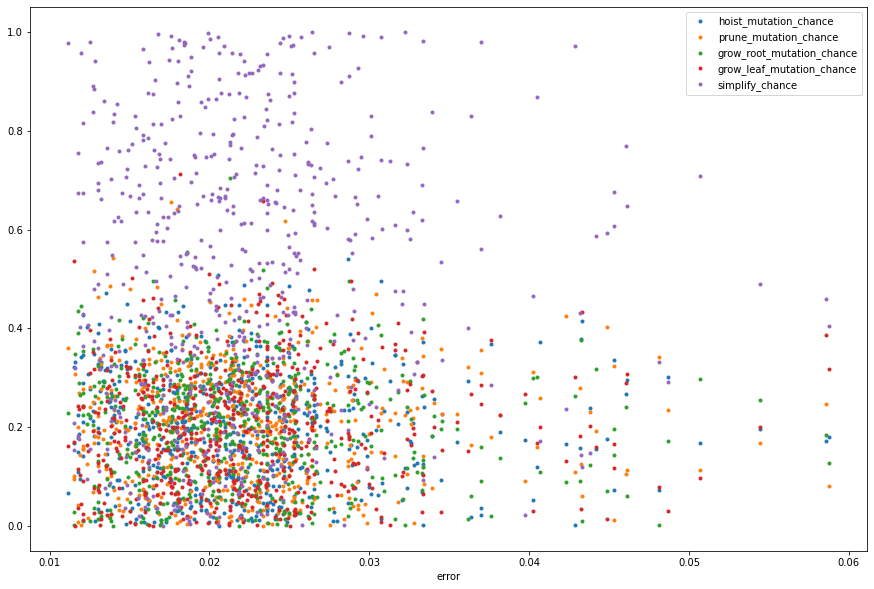

In [5]:
resdf.plot(y = ['hoist_mutation_chance', 'prune_mutation_chance', 'grow_root_mutation_chance', 'grow_leaf_mutation_chance', 'simplify_chance'], x='error', style='.', figsize=(15, 10))

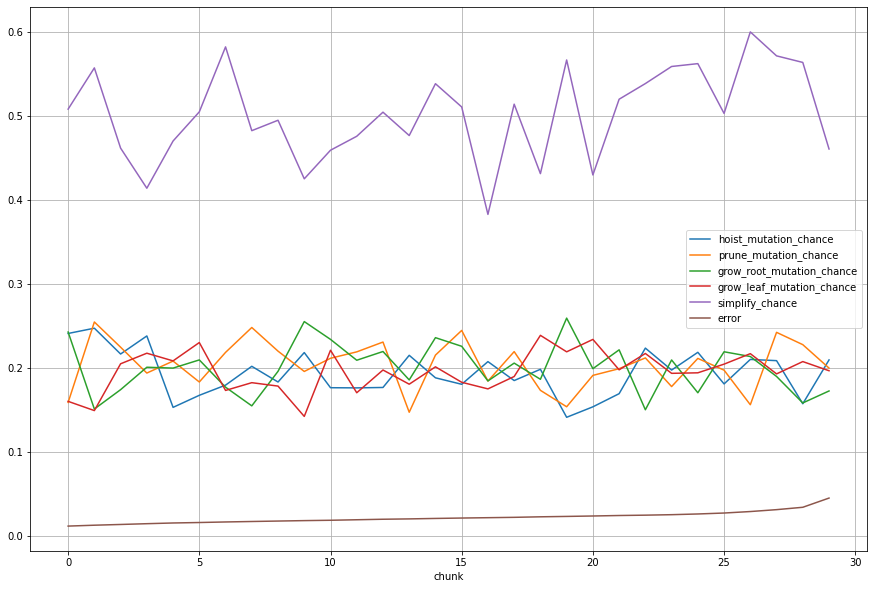

In [6]:
noerror = final_res.iloc[:, :-2]
noerror.plot(figsize=(15, 10), grid=True)
noerror /= noerror.mean()

In [8]:
final_res.iloc[:, :-1].corr('spearman')['error']

hoist_mutation_chance       -0.143048
prune_mutation_chance       -0.136819
grow_root_mutation_chance   -0.087875
grow_leaf_mutation_chance    0.271190
simplify_chance              0.337931
error                        1.000000
point_chance                 0.150167
Name: error, dtype: float64

In [9]:
r2 = Regressor(duration=30, verbose=True)
X = resdf.iloc[:,  :-2]
y = resdf.iloc[:, -2]
X['rand'] = np.random.random(np.shape(X.iloc[:, 0]))
X['rand2'] = np.random.random(np.shape(X.iloc[:, 0]))
X /= X.mean()
y /= y.mean()

In [10]:
r2.fit(X, y)

Time left  : 28.98s
Best so far: (0.47365412992482964, 27) (error, complexity)
Time left  : 27.95s
Best so far: (0.4722863452014628, 44) (error, complexity)
Time left  : 26.93s
Best so far: (0.44613613850403966, 33) (error, complexity)
Time left  : 25.91s
Best so far: (0.4261565096763383, 27) (error, complexity)
Time left  : 24.87s
Best so far: (0.41184211322620196, 28) (error, complexity)
Time left  : 23.86s
Best so far: (0.4004137128309949, 24) (error, complexity)
Time left  : 22.84s
Best so far: (0.4004137128309949, 24) (error, complexity)
Time left  : 21.83s
Best so far: (0.3935670662062512, 26) (error, complexity)
Time left  : 20.83s
Best so far: (0.3881632811640837, 28) (error, complexity)
Time left  : 19.83s
Best so far: (0.3881632811640837, 28) (error, complexity)
Time left  : 18.82s
Best so far: (0.3881632807676541, 32) (error, complexity)
Time left  : 17.82s
Best so far: (0.38756189557159026, 32) (error, complexity)
Time left  : 16.81s
Best so far: (0.38635182489420017, 31) (

In [11]:
"""
[{'error': 0.0028049765715300722,
  'complexity': 1,
  'program': Program('0.014426645859910924', 3)},
"""

r2.results()

[{'error': 0.5510451848080834, 'complexity': 1, 'program': Program('1.0', 8)},
 {'error': 0.54568598955809,
  'complexity': 3,
  'program': Program('pow 0.8887559312304673 $hoist_mutation_chance', 8)},
 {'error': 0.5441416588682153,
  'complexity': 5,
  'program': Program('pow pow 0.9984745146359403 $hoist_mutation_chance 50.76589009359972', 8)},
 {'error': 0.5303812833859168,
  'complexity': 6,
  'program': Program('pow div 0.9505970240823512 $hoist_mutation_chance log 1.1570683078510575', 8)},
 {'error': 0.522257397569668,
  'complexity': 8,
  'program': Program('pow div div 0.8887559312304673 $prune_mutation_chance $hoist_mutation_chance log 1.1570683078510575', 8)},
 {'error': 0.5027904413792436,
  'complexity': 9,
  'program': Program('add pow pow pow 0.9683588279479155 $hoist_mutation_chance $grow_leaf_mutation_chance 11.625171895139907 0.21438309796623947', 8)},
 {'error': 0.5025801885964666,
  'complexity': 11,
  'program': Program('add pow pow pow pow 0.9991763088008041 24.634

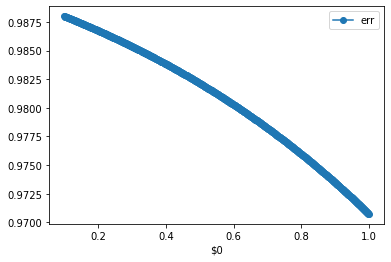

In [11]:
X = pd.DataFrame({'$0': np.linspace(0, 1, 1001)})
from symreg.ga import Program
p = Program(
    'pow 0.9891326826234386 exp $simplify_chance'
    .replace('$simplify_chance', '$0')
)
X['err'] = p.eval([X['$0']])
X[100:].plot(x='$0', y='err', marker='o')

We chose `mutation_children` to be 1 in production. It seems the other arguments do not matter - the error is very close to the constant program (complexity 1).